#Task 1: Combine CSV Files into a Single DataFrame

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [42]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from prophet import Prophet

In [3]:
data_path = '/content/drive/MyDrive/Final Project/Data'

In [4]:
csv_files = [
    'Tomatoes.csv', 'Sorghum.csv', 'Potatoes (Irish).csv', 'Peas (fresh).csv',
    'Oranges (big size).csv', 'Maize.csv', 'Chili (red).csv', 'Cassava.csv', 'Beans (dry).csv'
]

In [5]:
# Initialize an empty dictionary to hold DataFrames
dfs = {}

In [6]:
# Process each file
for file in csv_files:
    file_path = os.path.join(data_path, file)

    # Load the CSV file
    df = pd.read_csv(file_path)

    # Extract necessary columns
    df = df[['cm_name', 'mp_month', 'mp_year', 'mp_price']]

    # Fix: Create the 'date' column correctly
    df['date'] = pd.to_datetime(
        df[['mp_year', 'mp_month']].rename(columns={'mp_year': 'year', 'mp_month': 'month'}).assign(day=1)
    )

    # Set the 'date' column as the index
    df.set_index('date', inplace=True)

    # Extract the good's name
    good_name = df['cm_name'].iloc[0]

    # Keep only the 'mp_price' column and rename it to the good's name
    df = df[['mp_price']].rename(columns={'mp_price': good_name})

    # Add the DataFrame to the dictionary
    dfs[good_name] = df

In [7]:
# Combine all DataFrames into a single DataFrame using outer join
combined_data = pd.concat(
    [df[~df.index.duplicated(keep='first')] for df in dfs.values()],
    axis=1,
    join='outer'
)

# Display the combined DataFrame
print("Combined DataFrame")
print(combined_data.head())

Combined DataFrame
            Tomatoes  Sorghum  Potatoes (Irish)  Peas (fresh)  \
date                                                            
2008-01-01       NaN    177.5             77.50           NaN   
2008-02-01       NaN    160.0             77.50           NaN   
2008-03-01       NaN    160.0             75.00           NaN   
2008-04-01       NaN    170.0             73.75           NaN   
2008-05-01       NaN    202.5             72.50           NaN   

            Oranges (big size)  Maize  Chili (red)  Cassava  Beans (dry)  
date                                                                      
2008-01-01                 NaN  160.0          NaN    170.0       250.00  
2008-02-01                 NaN  140.0          NaN    172.5       260.00  
2008-03-01                 NaN  140.0          NaN    197.5       265.00  
2008-04-01                 NaN  140.0          NaN    245.0       255.00  
2008-05-01                 NaN  132.5          NaN    242.5       261.25  


# Task 2: Explore the Consolidated Data

In [8]:
# Summary statistics for all goods
print("### Summary Statistics")
print(combined_data.describe())

# Check for missing values in each column
print("\n### Missing Values")
print(combined_data.isna().sum())


### Summary Statistics
         Tomatoes     Sorghum  Potatoes (Irish)  Peas (fresh)  \
count   38.000000   96.000000         96.000000     60.000000   
mean   269.767108  284.027866        144.812415    727.797455   
std     62.516133   72.456958         39.107292    286.081310   
min    144.000000  160.000000         72.500000    277.500000   
25%    224.500000  232.395825        116.500025    518.750000   
50%    266.933350  262.950000        140.650000    679.166650   
75%    305.825000  348.125000        167.333325    795.833325   
max    411.250000  448.750000        259.000000   1666.666700   

       Oranges (big size)       Maize  Chili (red)     Cassava  Beans (dry)  
count           38.000000   96.000000    38.000000   96.000000    96.000000  
mean           555.767542  217.539583   777.017545  209.355727   329.793401  
std            128.765671   44.595518   359.967247   35.861754    65.514862  
min            326.666700  115.833300   206.250000  148.000000   227.083300  
2

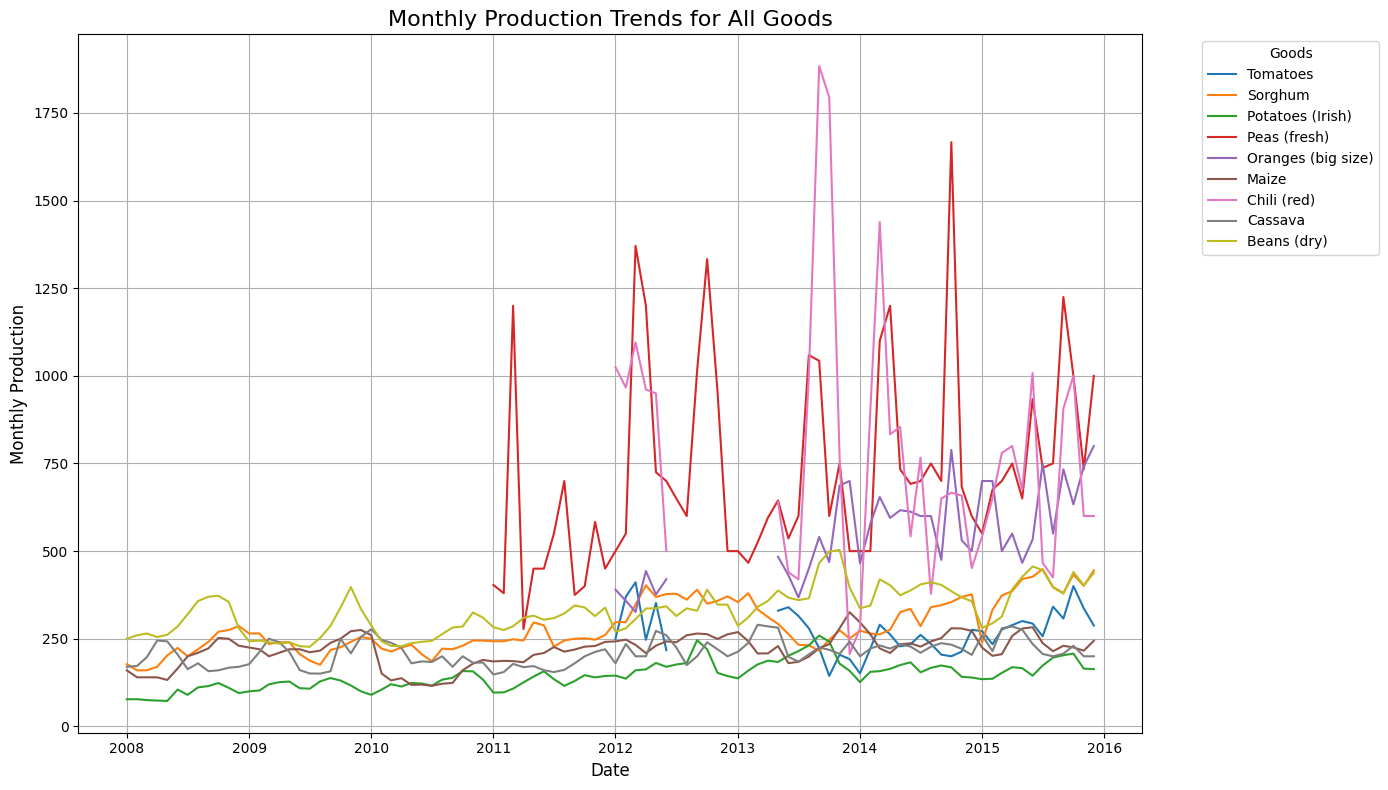

In [9]:
# Plot trends for all goods
plt.figure(figsize=(14, 8))
for column in combined_data.columns:
    plt.plot(combined_data.index, combined_data[column], label=column)

plt.title("Monthly Production Trends for All Goods", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Monthly Production", fontsize=12)
plt.legend(title="Goods", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


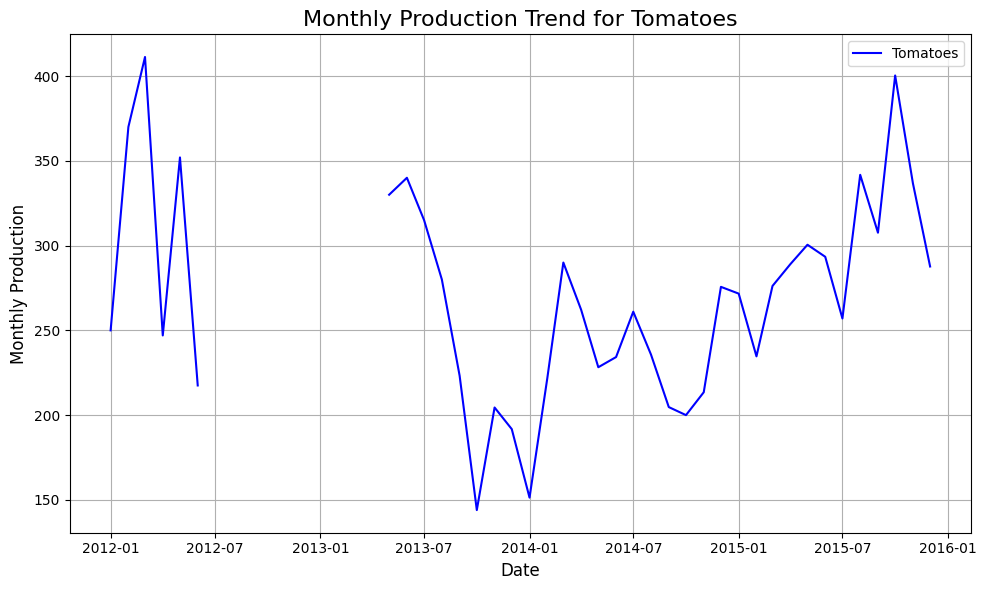

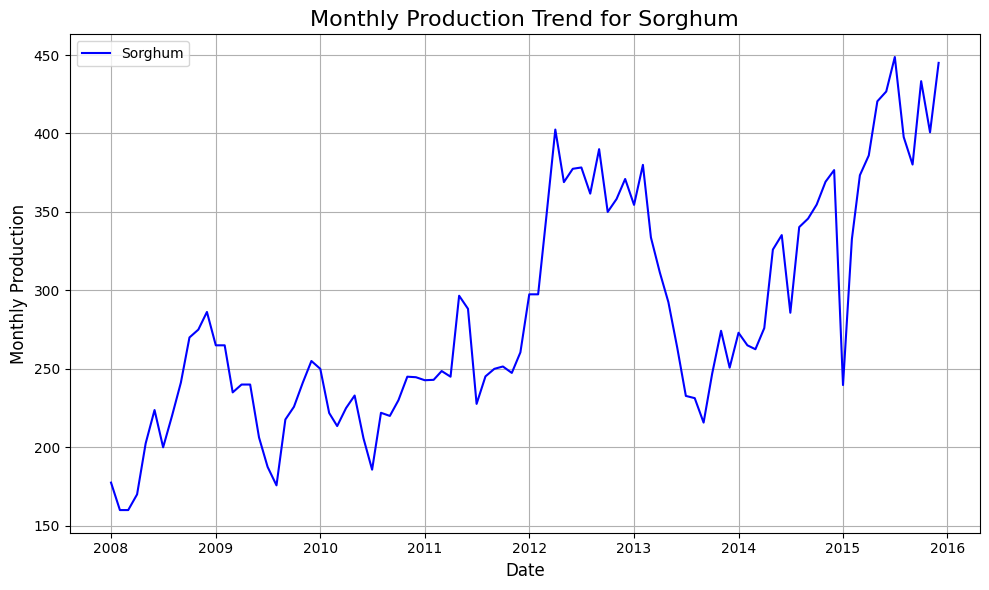

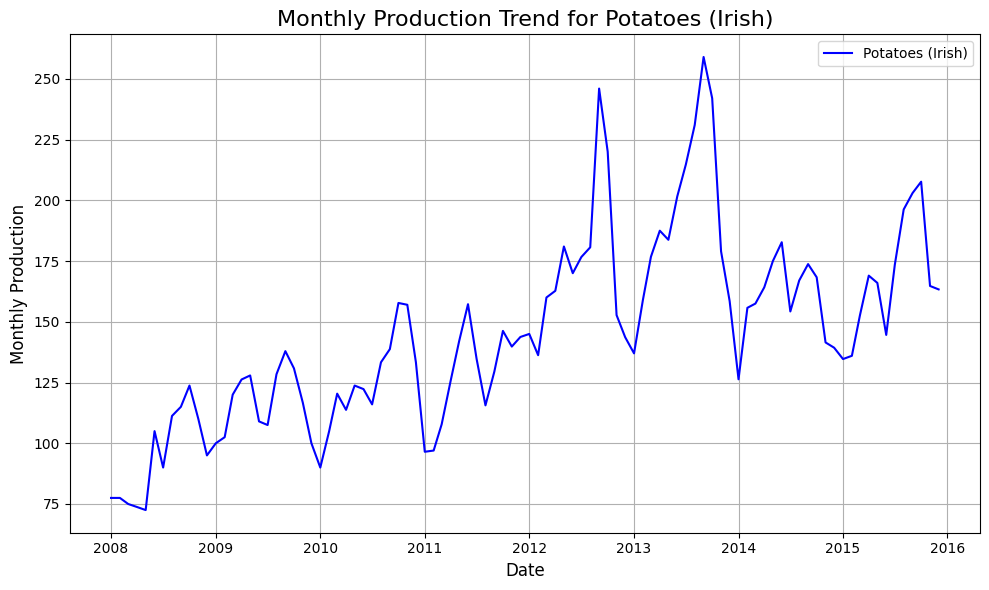

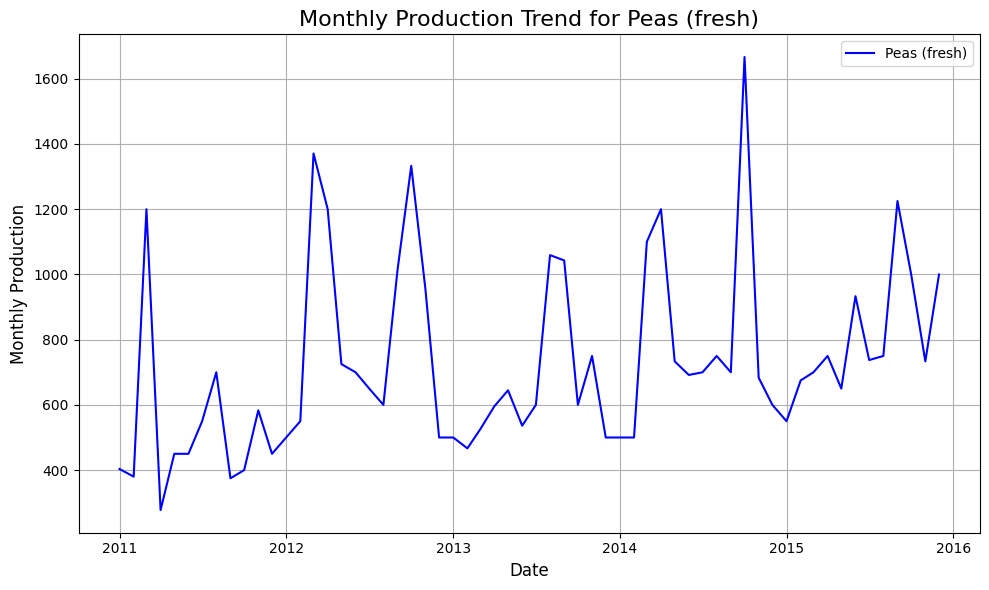

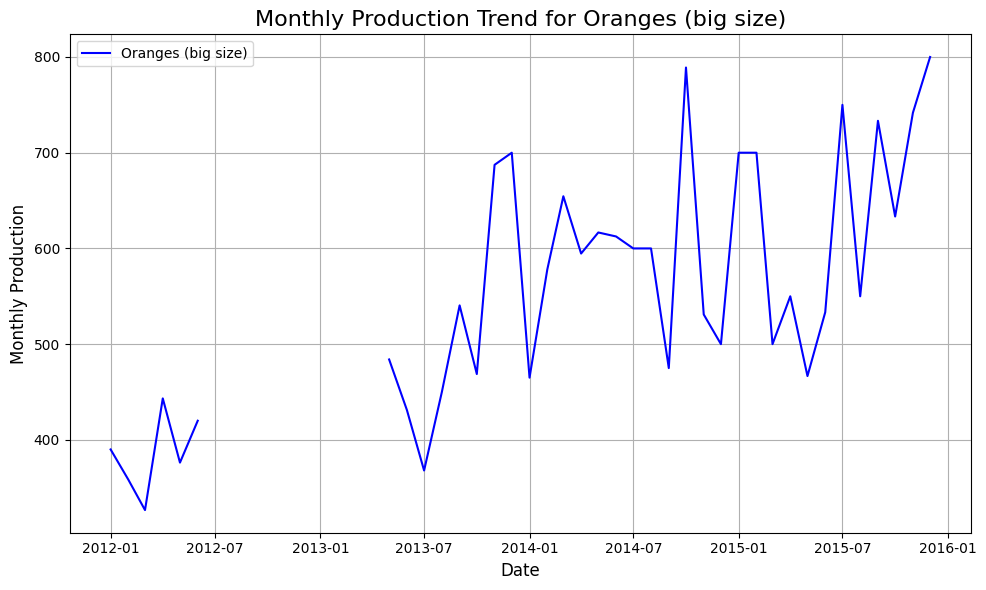

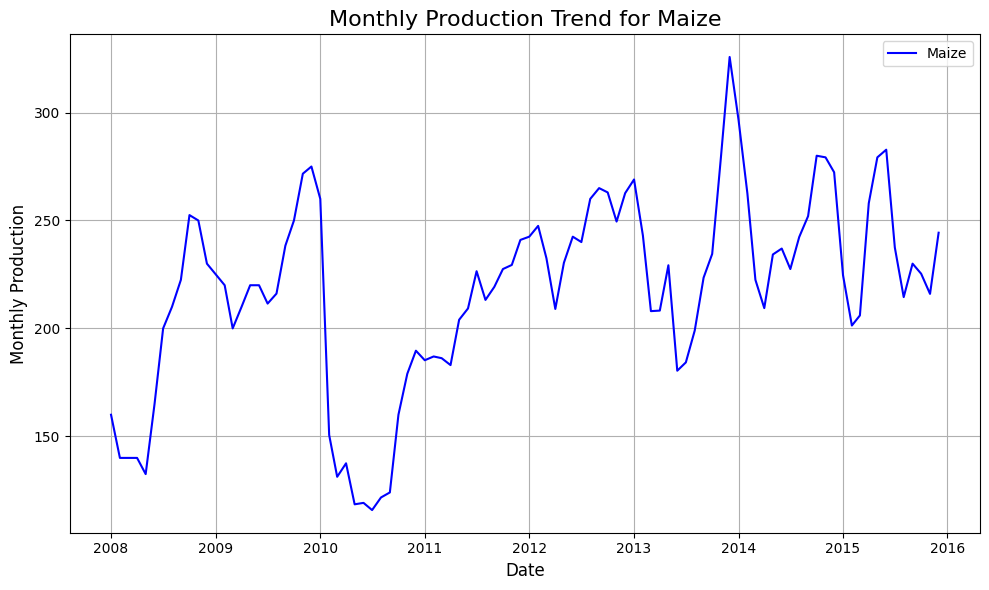

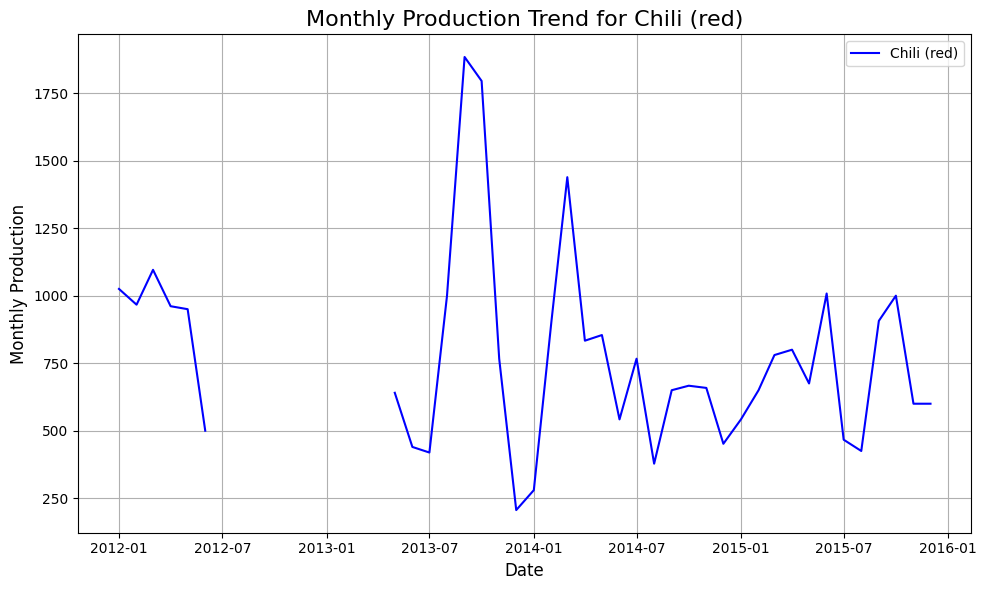

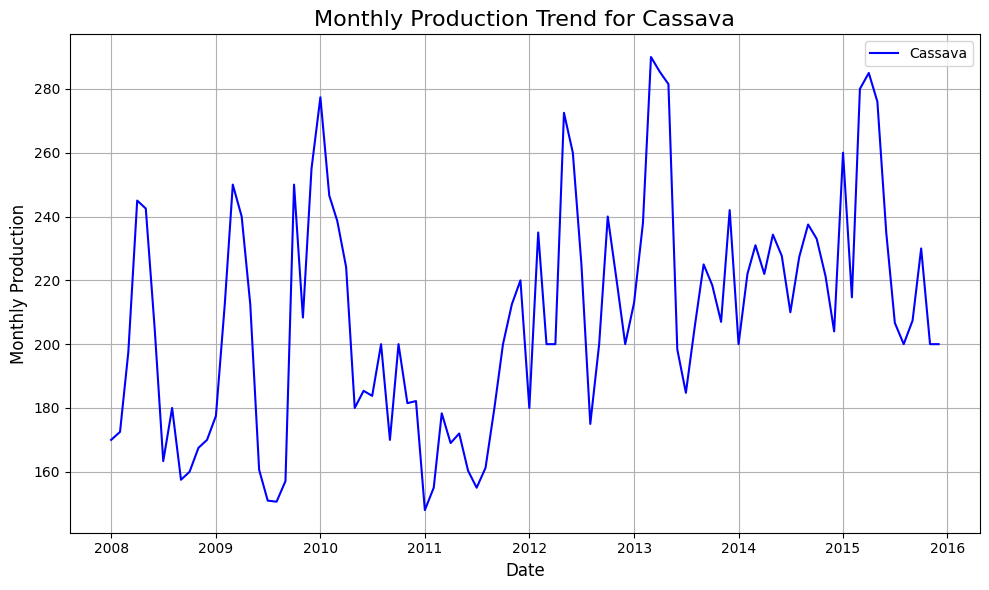

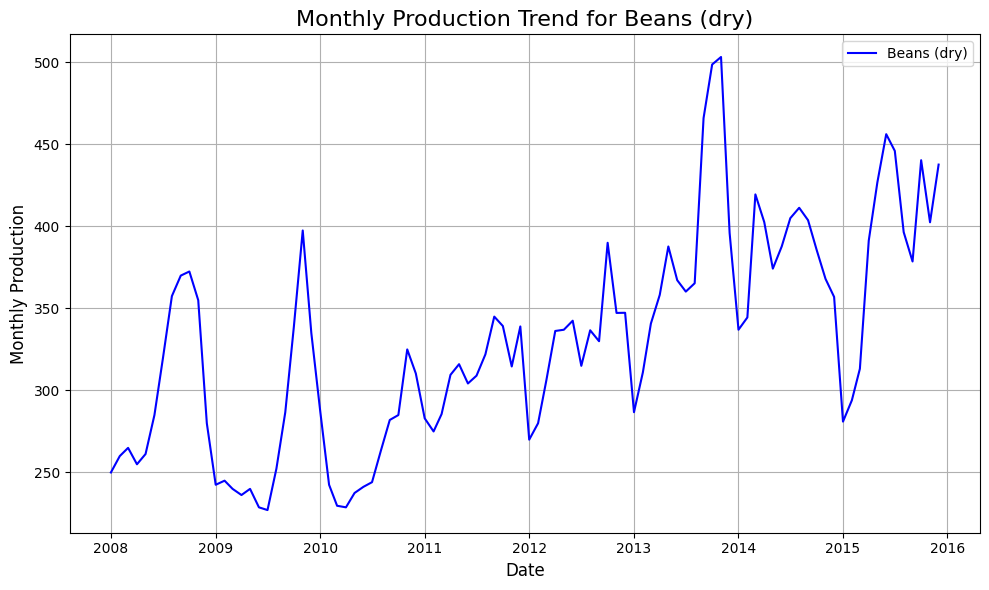

In [10]:
for column in combined_data.columns:
    plt.figure(figsize=(10, 6))
    plt.plot(combined_data.index, combined_data[column], label=column, color='blue')
    plt.title(f"Monthly Production Trend for {column}", fontsize=16)
    plt.xlabel("Date", fontsize=12)
    plt.ylabel("Monthly Production", fontsize=12)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


#Task 3: Handle Missing Values

In [11]:
# Fill missing values using forward fill
combined_data.fillna(method='ffill', inplace=True)

# Verify no missing values remain
print("### Missing Values After Forward Fill")
print(combined_data.isna().sum())

### Missing Values After Forward Fill
Tomatoes              48
Sorghum                0
Potatoes (Irish)       0
Peas (fresh)          36
Oranges (big size)    48
Maize                  0
Chili (red)           48
Cassava                0
Beans (dry)            0
dtype: int64


<ipython-input-11-5ce295fec770>:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  combined_data.fillna(method='ffill', inplace=True)


#Task 4: Analyze Similarities Between Products

In [12]:
# Calculate the correlation matrix
correlation_matrix = combined_data.corr()

# Display the correlation matrix
print("### Correlation Matrix")
print(correlation_matrix)


### Correlation Matrix
                    Tomatoes   Sorghum  Potatoes (Irish)  Peas (fresh)  \
Tomatoes            1.000000  0.213006          0.017445      0.189825   
Sorghum             0.213006  1.000000          0.535810      0.310038   
Potatoes (Irish)    0.017445  0.535810          1.000000      0.385220   
Peas (fresh)        0.189825  0.310038          0.385220      1.000000   
Oranges (big size) -0.032228  0.098135         -0.106858      0.249921   
Maize              -0.413496  0.558385          0.352400      0.090872   
Chili (red)         0.135011 -0.277183          0.348975      0.322874   
Cassava             0.018543  0.360419          0.290805      0.149909   
Beans (dry)        -0.057019  0.548737          0.665757      0.333034   

                    Oranges (big size)     Maize  Chili (red)   Cassava  \
Tomatoes                     -0.032228 -0.413496     0.135011  0.018543   
Sorghum                       0.098135  0.558385    -0.277183  0.360419   
Potatoes (I

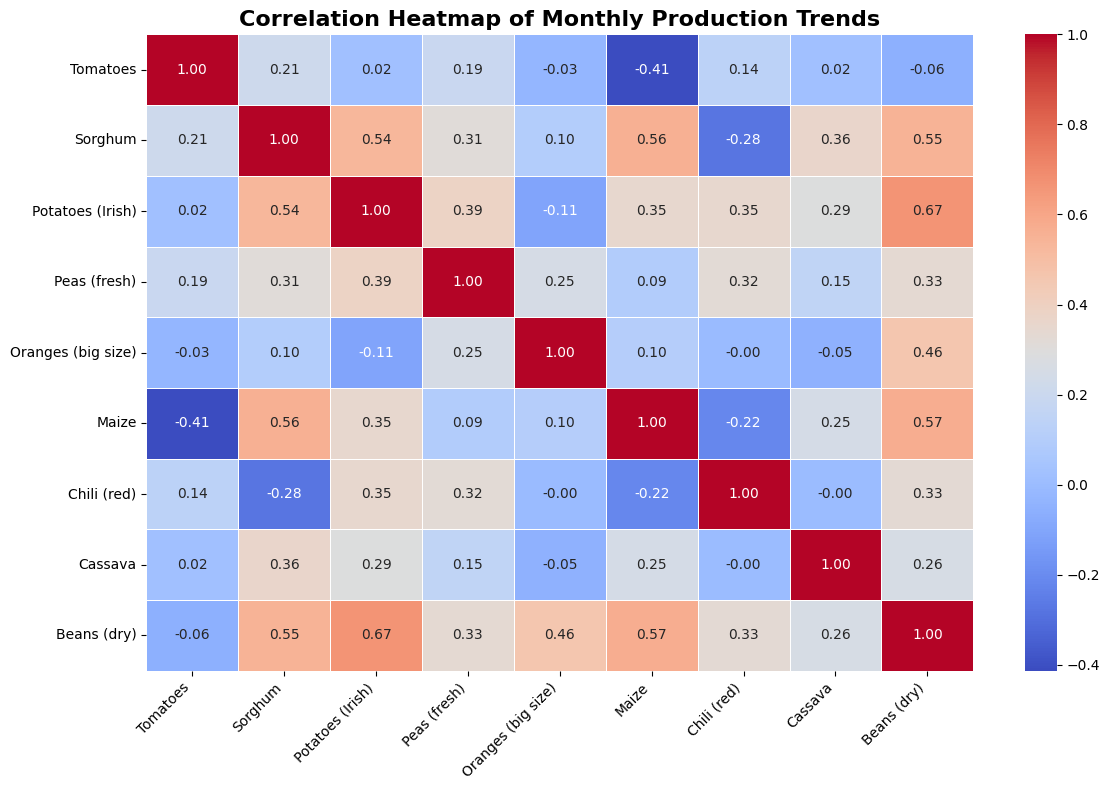

In [14]:
# Plot a heatmap for the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True, linewidths=0.5)
plt.title("Correlation Heatmap of Monthly Production Trends", fontsize=16, weight='bold')
plt.xticks(fontsize=10, rotation=45, ha='right')
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()


#Task 5: Forecasting for the Next 6 Months

>Moving Averages

In [15]:
# Select the Chili (red) column
chili_data = combined_data['Chili (red)']

# Calculate moving averages
chili_data_ma3 = chili_data.rolling(window=3).mean()  # 3-month moving average
chili_data_ma6 = chili_data.rolling(window=6).mean()  # 6-month moving average


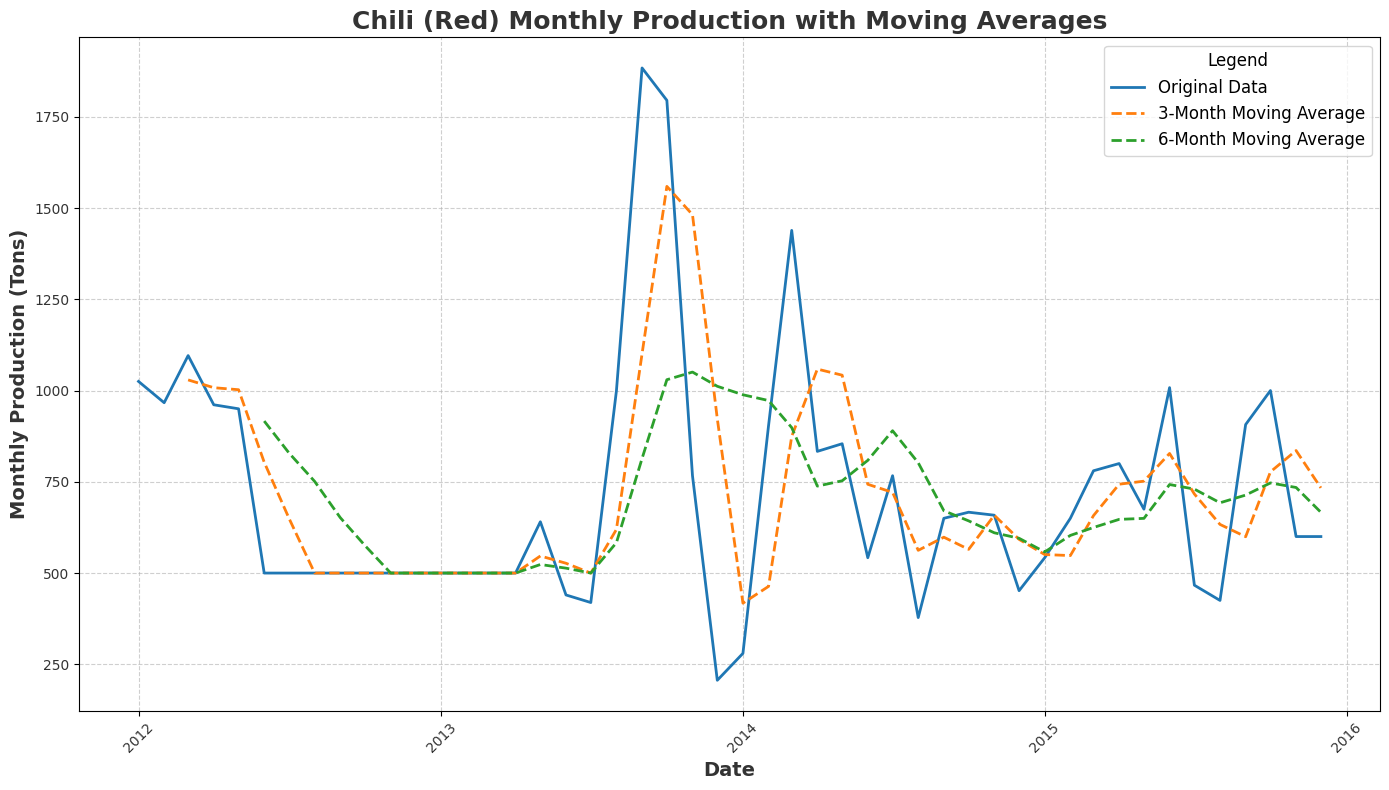

In [18]:
# Plot: Chili (Red) Production with Moving Averages
plt.figure(figsize=(14, 8))

# Original data
plt.plot(chili_data, label='Original Data', color='#1f77b4', linewidth=2)

# 3-month moving average
plt.plot(chili_data_ma3, label='3-Month Moving Average', color='#ff7f0e', linestyle='--', linewidth=2)

# 6-month moving average
plt.plot(chili_data_ma6, label='6-Month Moving Average', color='#2ca02c', linestyle='--', linewidth=2)

# Title and labels
plt.title('Chili (Red) Monthly Production with Moving Averages', fontsize=18, weight='bold', color='#333333')
plt.xlabel('Date', fontsize=14, weight='bold', color='#333333')
plt.ylabel('Monthly Production (Tons)', fontsize=14, weight='bold', color='#333333')

# Grid and Legend
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=12, title='Legend', title_fontsize=12)

# Customize x-axis formatting
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(fontsize=10, rotation=45, color='#333333')
plt.yticks(fontsize=10, color='#333333')

# Final layout adjustments
plt.tight_layout()
plt.show()


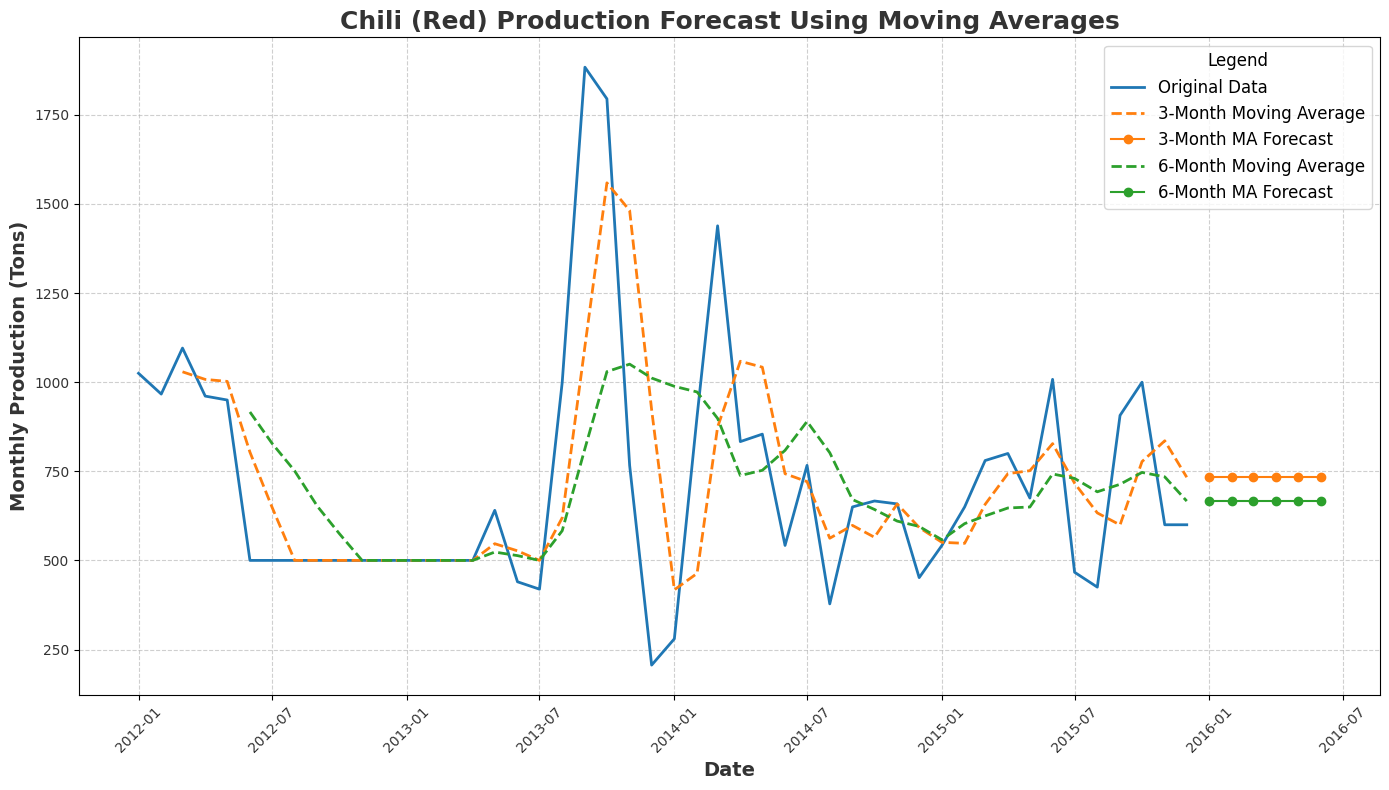

In [19]:
# Step 1: Extend the date index for 6 months
last_date = chili_data.index[-1]
future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=6, freq='MS')

# Step 2: Predict the next 6 months using the last available moving averages
forecast_ma3 = [chili_data_ma3.dropna().iloc[-1]] * 6  # Use the last value of the 3-month MA
forecast_ma6 = [chili_data_ma6.dropna().iloc[-1]] * 6  # Use the last value of the 6-month MA

# Step 3: Create a DataFrame for the forecast
forecast_df = pd.DataFrame({
    '3-Month Moving Average': forecast_ma3,
    '6-Month Moving Average': forecast_ma6
}, index=future_dates)

# Combine the original data and forecast for plotting
chili_forecast = pd.concat([chili_data, forecast_df['3-Month Moving Average'], forecast_df['6-Month Moving Average']], axis=1)

# Step 4: Plot the forecast
plt.figure(figsize=(14, 8))

# Original data
plt.plot(chili_data, label='Original Data', color='#1f77b4', linewidth=2)

# 3-month moving average with forecast
plt.plot(chili_data_ma3, label='3-Month Moving Average', color='#ff7f0e', linestyle='--', linewidth=2)
plt.plot(forecast_df.index, forecast_df['3-Month Moving Average'], label='3-Month MA Forecast', color='#ff7f0e', linestyle='-', marker='o')

# 6-month moving average with forecast
plt.plot(chili_data_ma6, label='6-Month Moving Average', color='#2ca02c', linestyle='--', linewidth=2)
plt.plot(forecast_df.index, forecast_df['6-Month Moving Average'], label='6-Month MA Forecast', color='#2ca02c', linestyle='-', marker='o')

# Title and labels
plt.title('Chili (Red) Production Forecast Using Moving Averages', fontsize=18, weight='bold', color='#333333')
plt.xlabel('Date', fontsize=14, weight='bold', color='#333333')
plt.ylabel('Monthly Production (Tons)', fontsize=14, weight='bold', color='#333333')

# Grid and Legend
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=12, title='Legend', title_fontsize=12)

# Customize x-axis formatting
plt.xticks(fontsize=10, rotation=45, color='#333333')
plt.yticks(fontsize=10, color='#333333')

# Final layout adjustments
plt.tight_layout()
plt.show()


>Exponential Smoothing

In [37]:
print("Missing values in Chili (Red):", chili_data.isna().sum())

Missing values in Chili (Red): 48


In [38]:
# Fill missing values using forward fill
chili_data_filled = chili_data.ffill()

# If there are still missing values, use backward fill to fill them at the start
chili_data_filled = chili_data_filled.bfill()

# Verify no missing values remain
print("Missing values after filling:", chili_data_filled.isna().sum())


Missing values after filling: 0


In [39]:
# Fit the Holt-Winters model
model = ExponentialSmoothing(
    chili_data_filled,
    seasonal='add',
    seasonal_periods=12,
    trend='add'
)
fit = model.fit()

# Forecast for the next 6 months
forecast_hw = fit.forecast(steps=6)

# Print forecasted values
print("Holt-Winters Forecast for the Next 6 Months:")
print(forecast_hw)


Holt-Winters Forecast for the Next 6 Months:
2016-01-01    649.085628
2016-02-01    735.095661
2016-03-01    826.790470
2016-04-01    734.731481
2016-05-01    746.446337
2016-06-01    673.101632
Freq: MS, dtype: float64


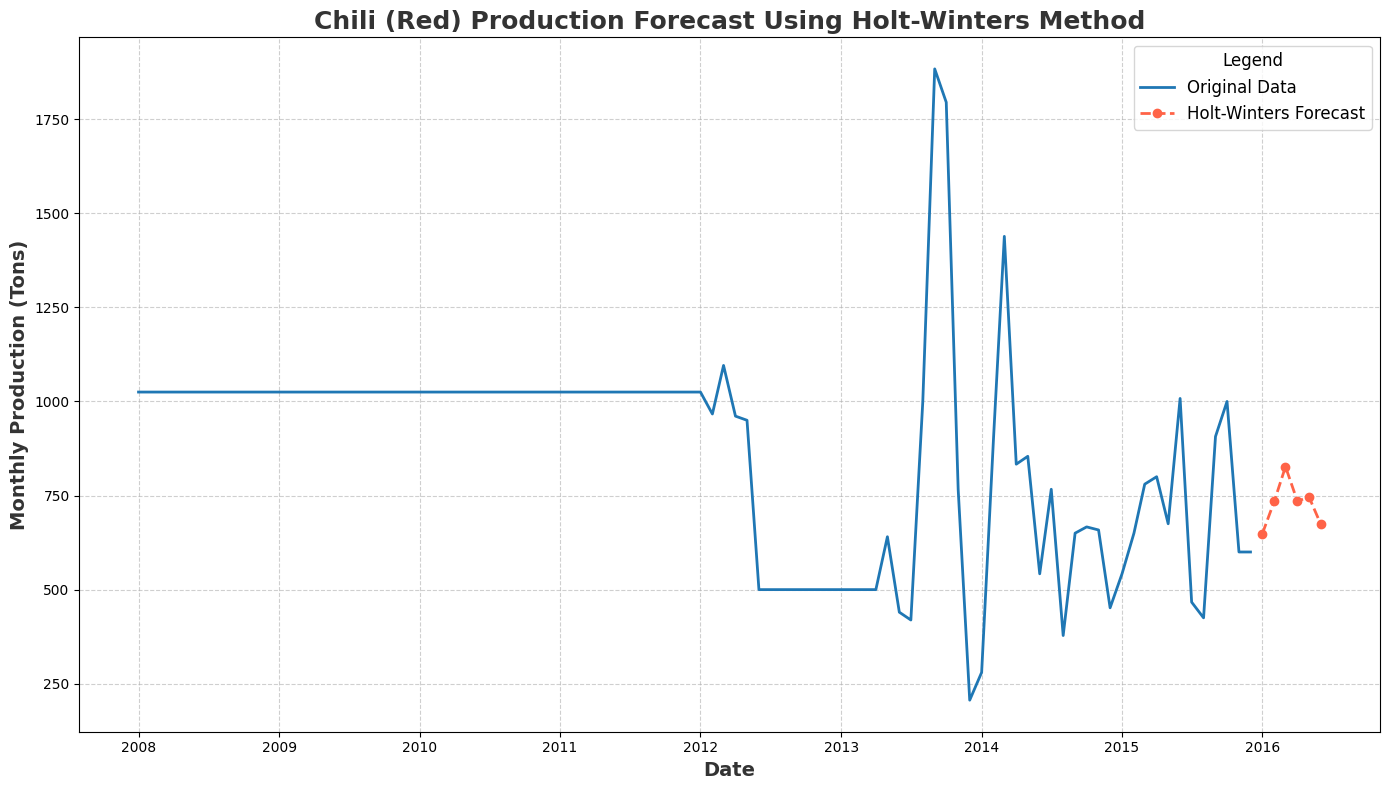

In [40]:
# Plot the results
plt.figure(figsize=(14, 8))
plt.plot(chili_data_filled, label='Original Data', color='#1f77b4', linewidth=2)
plt.plot(forecast_hw.index, forecast_hw, label='Holt-Winters Forecast', color='#ff6347', linestyle='--', marker='o', linewidth=2)
plt.title('Chili (Red) Production Forecast Using Holt-Winters Method', fontsize=18, weight='bold', color='#333333')
plt.xlabel('Date', fontsize=14, weight='bold', color='#333333')
plt.ylabel('Monthly Production (Tons)', fontsize=14, weight='bold', color='#333333')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=12, title='Legend', title_fontsize=12)
plt.tight_layout()
plt.show()


>Prophet

In [41]:
# Prepare data for Prophet
prophet_data = chili_data_filled.reset_index()[['date', 'Chili (red)']]
prophet_data.columns = ['ds', 'y']  # Rename columns to 'ds' and 'y'

In [43]:
# Create a Prophet model instance
prophet_model = Prophet(
    yearly_seasonality=True,  # Set to True to include yearly seasonality by default
    seasonality_mode='additive',  # Change to 'multiplicative' if needed
)

# Fit the model to the data
prophet_model.fit(prophet_data)

# Forecast the next 6 months
future = prophet_model.make_future_dataframe(periods=6, freq='M')
forecast_prophet = prophet_model.predict(future)


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfmiz9d9o/prev99lw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfmiz9d9o/bh9kyios.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10004', 'data', 'file=/tmp/tmpfmiz9d9o/prev99lw.json', 'init=/tmp/tmpfmiz9d9o/bh9kyios.json', 'output', 'file=/tmp/tmpfmiz9d9o/prophet_modelabwwqs_b/prophet_model-20241128063717.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
06:37:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:37:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.10/dist-packages

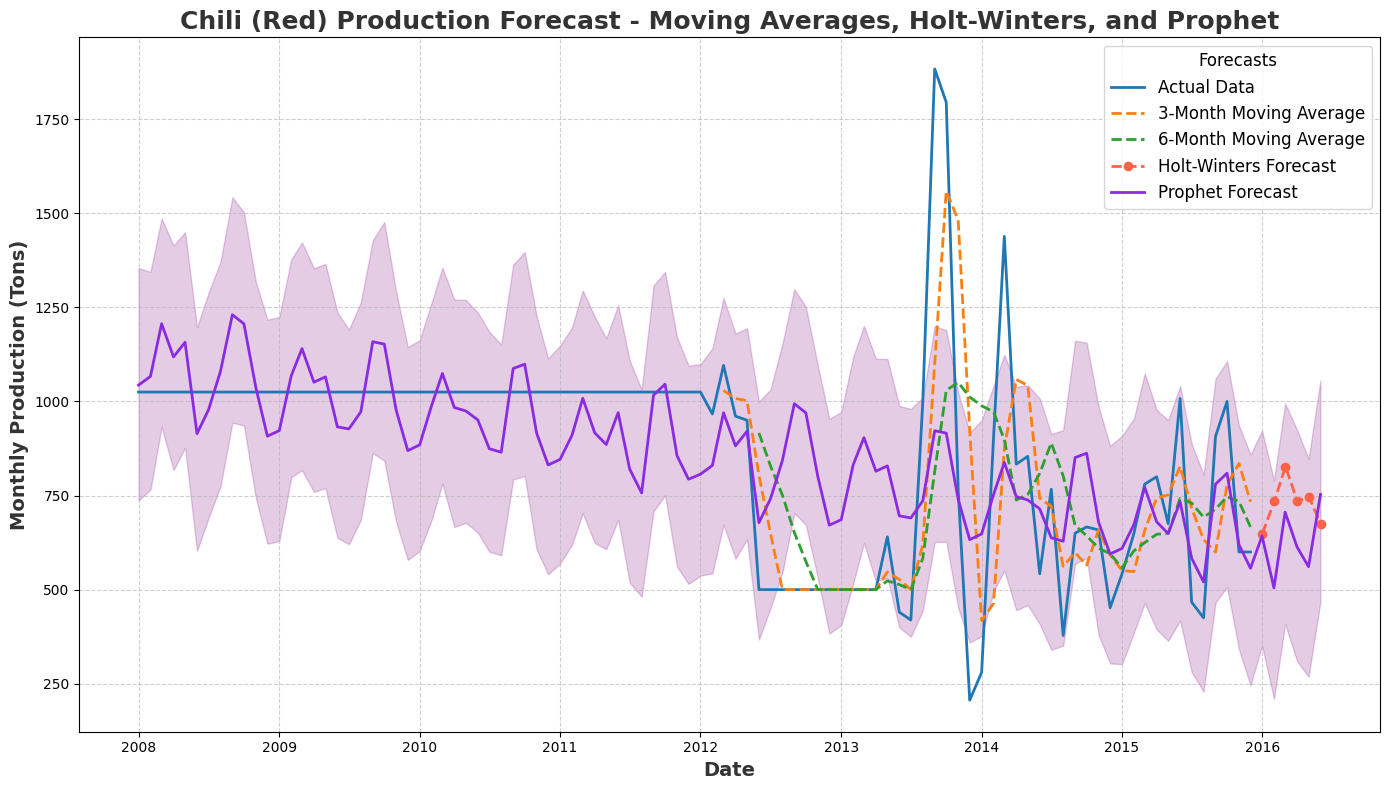

In [44]:
# Plot the actual time series and forecasts
plt.figure(figsize=(14, 8))

# Plot the actual data
plt.plot(chili_data_filled, label='Actual Data', color='#1f77b4', linewidth=2)

# Plot the 3-month and 6-month moving averages
plt.plot(chili_data_ma3, label='3-Month Moving Average', color='#ff7f0e', linestyle='--', linewidth=2)
plt.plot(chili_data_ma6, label='6-Month Moving Average', color='#2ca02c', linestyle='--', linewidth=2)

# Plot Holt-Winters forecast
plt.plot(forecast_hw.index, forecast_hw, label='Holt-Winters Forecast', color='#ff6347', linestyle='--', marker='o', linewidth=2)

# Plot Prophet forecast
plt.plot(forecast_prophet['ds'], forecast_prophet['yhat'], label='Prophet Forecast', color='#8a2be2', linestyle='-', linewidth=2)

# Plot the uncertainty intervals for Prophet
plt.fill_between(forecast_prophet['ds'], forecast_prophet['yhat_lower'], forecast_prophet['yhat_upper'], color='purple', alpha=0.2)

# Title and labels
plt.title('Chili (Red) Production Forecast - Moving Averages, Holt-Winters, and Prophet', fontsize=18, weight='bold', color='#333333')
plt.xlabel('Date', fontsize=14, weight='bold', color='#333333')
plt.ylabel('Monthly Production (Tons)', fontsize=14, weight='bold', color='#333333')

# Grid and Legend
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=12, title='Forecasts', title_fontsize=12)
plt.tight_layout()
plt.show()
